# Extract data from Continuous-Drug Combination DataBase

The purpose of this notebook is to extract and format drug combination data
Additionally, the purpose of this notebook is to reconcile DrugBank and PubChem IDs that are found in the data.


## Notebook Requirements:
*  Model genes **must** have the at least one of following annotations stored in the `object.annotation`. Values are expected to be seperated by semicolons. Accepted keys currently include:
    * `"drugbank"`
* Note: Requires internet connection to download information from the [C-DCDB](https://icc.ise.bgu.ac.il/medical_ai/CDCDB/).

### Citations
Shtar G, Azulay L, Nizri O, Rokach L, Shapira B. CDCDB: A large and continuously updated drug combination database. Sci Data. 2022 Jun 2;9(1):263. doi: 10.1038/s41597-022-01360-z. PMID: 35654801; PMCID: PMC9163158.

## Setup
### Import packages

In [1]:
from collections import defaultdict
from itertools import combinations

import matplotlib.pyplot as plt
import pandas as pd
from rbc_gem_utils import (
    GEM_NAME,
    build_string,
    compare_tables,
    get_annotation_df,
    get_dirpath,
    read_cobra_model,
    show_versions,
    split_string,
    visualize_comparison,
)
from rbc_gem_utils.database import CDCDB_DB_TAG
from rbc_gem_utils.util import explode_column

# Display versions of last time notebook ran and worked
show_versions()


Package Information
-------------------
rbc-gem-utils 0.0.2

Dependency Information
----------------------
beautifulsoup4                       4.13.4
bio                                 missing
cobra                                0.29.1
depinfo                               2.2.0
gurobipy                             12.0.2
matplotlib                           3.10.3
matplotlib-venn                       1.1.2
memote                               0.17.0
networkx                              3.4.2
notebook                              7.4.2
openpyxl                              3.1.5
pandas                                2.2.3
pre-commit                            4.2.0
rbc-gem-utils[database,network,vis] missing
requests                             2.32.3
scipy                                1.15.3
seaborn                              0.13.2

Build Tools Information
-----------------------
conda      25.3.1
pip          25.0
setuptools 78.1.1
wheel      0.45.1

Platform Information
-

## Set notebook options

In [2]:
db_tag = CDCDB_DB_TAG

compare_figsize = (5, 5)
compare = True
display_nunique = True
overwrite = True

## Load RBC-GEM model

In [3]:
model_dirpath = get_dirpath("model")
model = read_cobra_model(filename=model_dirpath / f"{GEM_NAME}.xml")
model

Restricted license - for non-production use only - expires 2026-11-23


Name,RBC_GEM
Memory address,265f3717b60
Number of metabolites,2157
Number of reactions,3275
Number of genes,820
Number of groups,78
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


#### Load annotations

In [4]:
annotation_type = "genes"
df_model_mappings = get_annotation_df(
    getattr(model, annotation_type), ["drugbank", "pubchem.compound"]
).rename({"id": annotation_type}, axis=1)
for col in df_model_mappings.columns:
    df = (
        df_model_mappings[col]
        .apply(lambda x: split_string(x))
        .explode(col)
        .drop_duplicates()
    )
    print(f"{df.name}: {df.nunique()}")

drugbank_ids = (
    explode_column(df_model_mappings, "drugbank")["drugbank"].dropna().unique()
)
pubchem_ids = (
    explode_column(df_model_mappings, "pubchem.compound")["pubchem.compound"]
    .dropna()
    .unique()
)
df_model_mappings

genes: 820
drugbank: 2712
pubchem.compound: 1166


,genes,drugbank,pubchem.compound
0,RPE,DB00153,5280793
1,RPIA,DB01756,<NA>
2,SORD,DB00157;DB04478,<NA>
3,AKR7A2,<NA>,<NA>
4,SRM,DB00118,34755
...,...,...,...
815,USP5,<NA>,<NA>
816,VCPIP1,<NA>,<NA>
817,VPS4B,<NA>,<NA>
818,WDR77,<NA>,<NA>


## Load C-DCDB data and identify combinations

In [5]:
use_interim = False

database_dirpath = get_dirpath(
    "database", db_tag, use_temp="interim" if use_interim else None
)
annotation_dirpath = get_dirpath(
    "annotation", use_temp="interim" if use_interim else None
)

# Ensure directories exist
database_dirpath.mkdir(exist_ok=True, parents=True)
annotation_dirpath.mkdir(exist_ok=True, parents=True)

df_database_simplified = pd.read_csv(
    database_dirpath / "web_preview.csv", index_col=0, dtype=str
)

### Format data

In [6]:
df_database_simplified = df_database_simplified.reset_index(drop=False)
# Space left here if additional metadata needs to be added

df_combinations = df_database_simplified.copy().fillna("")
df_combinations["drugs"] = df_combinations["drugs"].apply(
    lambda x: sorted(x.split(","))
)
df_combinations["drugbank_identifiers"] = df_combinations["drugbank_identifiers"].apply(
    lambda x: x.split(";")
)
df_combinations["pubchem_identifiers"] = df_combinations["pubchem_identifiers"].apply(
    lambda x: [s.lstrip("CID") for s in x.split(";")]
)
df_combinations

,drugs,drugbank_identifiers,pubchem_identifiers,source_id,source
0,"[Foscarnet, Ganciclovir]","[DB01004, DB00529]","[NA, NA]",NCT00000134,clinicaltrials.gov
1,"[Foscarnet, Ganciclovir]","[DB01004, DB00529]","[NA, NA]",NCT00000136,clinicaltrials.gov
2,"[Foscarnet, Ganciclovir]","[DB00529, DB01004]","[NA, NA]",NCT00000136,clinicaltrials.gov
3,"[Clozapine, Cycloserine]","[DB00363, DB00260]","[2818, 6234]",NCT00000372,clinicaltrials.gov
4,"[Alendronic acid, Teriparatide]","[DB00630, DB06285]","[2088, 16133850]",NCT00000400,clinicaltrials.gov
...,...,...,...,...,...
41669,"[Desogestrel, Ethinylestradiol]","[DB00304, DB00977]","[40973, 5991]",,orangebook
41670,"[Ethinylestradiol, Norgestimate]","[DB00977, DB00957]","[5991, 6540478]",,orangebook
41671,"[Ethinylestradiol, Ferrous fumarate, Norethist...","[DB00977, DB14491, DB00717]","[5991, 6433164, NA]",,orangebook
41672,"[Ethinylestradiol, Ferrous fumarate, Norethist...","[DB00977, DB14491, DB00717]","[5991, 6433164, 6230]",,orangebook


In [7]:
df_alias_mapping = df_combinations.loc[
    :, ["drugbank_identifiers", "pubchem_identifiers"]
].explode(["drugbank_identifiers", "pubchem_identifiers"])
df_alias_mapping = (
    df_alias_mapping.replace("NA", float("nan"))
    .drop_duplicates()
    .reset_index(drop=True)
)
df_alias_mapping = (
    df_alias_mapping.rename(
        {"drugbank_identifiers": "drugbank", "pubchem_identifiers": "pubchem.compound"},
        axis=1,
    )
    .dropna()
    .reset_index(drop=True)
)
if overwrite:
    df_alias_mapping.to_csv(database_dirpath / "aliases.tsv", sep="\t")
df_alias_mapping

,drugbank,pubchem.compound
0,DB00363,2818
1,DB00260,6234
2,DB00630,2088
3,DB06285,16133850
4,DB01104,68617
...,...,...
3258,DB01501,34328
3259,DB00233,2724368
3260,DB00790,12068809
3261,DB00823,9270


#### Extract as model annotations

genes: 478
drugbank: 2728
pubchem.compound: 1324


,genes,drugbank,pubchem.compound
0,AARS1,DB00160,
1,ABCA1,DB00163;DB00171;DB00675;DB01016;DB01599;DB11635,14985;2733525;2733526;3488;4912;5957
2,ABCB1,DB00027;DB00052;DB00080;DB00091;DB00104;DB0017...,10034073;10077129;10077130;10096344;10113978;1...
3,ABCB4,DB06191;DB06207;DB06414;DB12799;DB14068;DB14070,193962;5312125
4,ABCC1,DB00115;DB00143;DB00171;DB00224;DB00286;DB0032...,105111;10608;107969;107970;11243969;123596;124...
...,...,...,...
473,VDAC2,DB01375;DB06098,
474,VDAC3,DB01375;DB06098,
475,WARS1,DB00150;DB01831;DB04537,6305
476,YARS1,DB00135;DB01766;DB02709;DB03978;DB07205;DB0837...,445154;6057


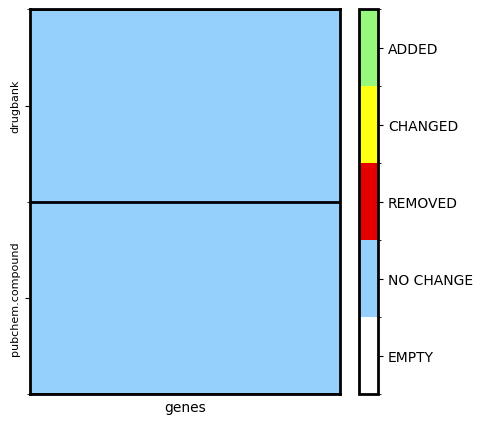

In [8]:
annotation_type = "genes"
# Format as model annotations
df_model_drugs = (
    df_model_mappings.set_index(annotation_type)["drugbank"]
    .apply(split_string)
    .explode()
    .dropna()
    .reset_index()
)
df_annotations = df_model_drugs.merge(
    df_alias_mapping, left_on="drugbank", right_on="drugbank", how="left"
)
df_model_drugs = (
    df_model_mappings.set_index(annotation_type)["pubchem.compound"]
    .apply(split_string)
    .explode()
    .dropna()
    .reset_index()
)

df_annotations = pd.concat(
    (
        df_annotations,
        df_model_drugs.merge(
            df_alias_mapping,
            left_on="pubchem.compound",
            right_on="pubchem.compound",
            how="left",
        ),
    ),
    axis=0,
)
df_annotations["pubchem.compound"] = df_annotations["pubchem.compound"].str.lstrip(
    "CID"
)
df_annotations = df_annotations.groupby(annotation_type, as_index=False).agg(
    lambda x: build_string(sorted(x.dropna().unique()))
)


if compare:
    try:
        df_previous = pd.read_csv(
            annotation_dirpath / f"{annotation_type}_{CDCDB_DB_TAG}.tsv",
            sep="\t",
            index_col=0,
            dtype=str,
        )
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=[annotation_type])
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    df_comparision = compare_tables(
        df_previous.set_index(annotation_type),
        df_annotations.set_index(annotation_type),
    )
    ax.yaxis.set_tick_params(labelsize=8)
    ax = visualize_comparison(df_comparision)


if display_nunique:
    for col in df_annotations.columns:
        df = (
            df_annotations[col]
            .apply(lambda x: split_string(x))
            .explode(col)
            .drop_duplicates()
        )
        print(f"{df.name}: {df.nunique()}")

if overwrite:
    df_annotations.to_csv(
        annotation_dirpath / f"{annotation_type}_{CDCDB_DB_TAG}.tsv", sep="\t"
    )

df_annotations

### Map against model

In [9]:
# TODO deal with combinations that have NA in the identifier
# TODO deal with PubChem compounds
indicies_to_keep = sorted(
    {
        idx
        for idx, row in df_combinations["drugbank_identifiers"].dropna().items()
        if not set(row).difference(set(drugbank_ids))
    }
    # .union([
    #     idx
    #     for idx, row in df_combinations["pubchem_identifiers"].dropna().items()
    #     if not set(row).difference(set(pubchem_ids))
)

df_model_combinations = df_combinations.loc[indicies_to_keep].reset_index(drop=True)
df_model_combinations

,drugs,drugbank_identifiers,pubchem_identifiers,source_id,source
0,"[Foscarnet, Ganciclovir]","[DB01004, DB00529]","[NA, NA]",NCT00000134,clinicaltrials.gov
1,"[Foscarnet, Ganciclovir]","[DB01004, DB00529]","[NA, NA]",NCT00000136,clinicaltrials.gov
2,"[Foscarnet, Ganciclovir]","[DB00529, DB01004]","[NA, NA]",NCT00000136,clinicaltrials.gov
3,"[Aldesleukin, Artesunate]","[DB09274, DB00041]","[6917864, NA]",NCT00000948,clinicaltrials.gov
4,"[Estradiol, Progesterone]","[DB00396, DB00783]","[5994, 5757]",NCT00001481,clinicaltrials.gov
...,...,...,...,...,...
10695,"[Elbasvir, Grazoprevir]","[DB11574, DB11575]","[71661251, 44603531]",,orangebook
10696,"[Ethinylestradiol, Norgestimate]","[DB00977, DB00957]","[5991, 6540478]",,orangebook
10697,"[Ethinylestradiol, Ferrous fumarate, Norethist...","[DB00977, DB14491, DB00717]","[5991, 6433164, NA]",,orangebook
10698,"[Ethinylestradiol, Ferrous fumarate, Norethist...","[DB00977, DB14491, DB00717]","[5991, 6433164, 6230]",,orangebook


### Keep only pairwise combinations
* Combinations with more than two drug components are split into combination pairs

In [10]:
idx = 0
all_data = defaultdict(dict)
for i, row in df_model_combinations.iterrows():
    for identifiers in row[["drugbank_identifiers", "pubchem_identifiers"]].values:
        if "NA" in set(identifiers):
            continue
        values = row.to_dict()
        for combo in combinations(identifiers, 2):
            values.update({"node_A": combo[0], "node_B": combo[1]})
            all_data[idx] = values
            idx += 1
df_interactions = pd.DataFrame.from_dict(all_data, orient="index")
df_interactions["edge_type"] = "drug-drug"
df_interactions["edge_subtype"] = "effective-combination"
df_interactions["edge_source"] = df_interactions["source"].apply(
    lambda x: build_string([CDCDB_DB_TAG, x])
)
# Use the join method instead of the build_string to avoid losing drugs that interact with themselves for being "duplicate" values
df_interactions["drugs"] = df_interactions["drugs"].apply(lambda x: ";".join(x))
df_interactions["drugbank_identifiers"] = df_interactions["drugbank_identifiers"].apply(
    lambda x: ";".join(x)
)
df_interactions["pubchem_identifiers"] = df_interactions["pubchem_identifiers"].apply(
    lambda x: ";".join(x)
)
df_interactions = df_interactions.drop_duplicates(
    ["node_A", "node_B", "drugs", "drugbank_identifiers", "pubchem_identifiers"]
)
df_interactions = df_interactions.reset_index(drop=True)
df_interactions.to_csv(
    database_dirpath / f"EffectiveCombos_{CDCDB_DB_TAG}.tsv",
    sep="\t",
)
df_interactions

,drugs,drugbank_identifiers,pubchem_identifiers,source_id,source,node_A,node_B,edge_type,edge_subtype,edge_source
0,Foscarnet;Ganciclovir,DB01004;DB00529,NA;NA,NCT00000134,clinicaltrials.gov,DB01004,DB00529,drug-drug,effective-combination,CDCDB;clinicaltrials.gov
1,Foscarnet;Ganciclovir,DB00529;DB01004,NA;NA,NCT00000136,clinicaltrials.gov,DB00529,DB01004,drug-drug,effective-combination,CDCDB;clinicaltrials.gov
2,Aldesleukin;Artesunate,DB09274;DB00041,6917864;NA,NCT00000948,clinicaltrials.gov,DB09274,DB00041,drug-drug,effective-combination,CDCDB;clinicaltrials.gov
3,Estradiol;Progesterone,DB00396;DB00783,5994;5757,NCT00001481,clinicaltrials.gov,DB00396,DB00783,drug-drug,effective-combination,CDCDB;clinicaltrials.gov
4,Estradiol;Progesterone,DB00396;DB00783,5994;5757,NCT00001481,clinicaltrials.gov,5994,5757,drug-drug,effective-combination,CDCDB;clinicaltrials.gov
...,...,...,...,...,...,...,...,...,...,...
11325,Ethinylestradiol;Ferrous fumarate;Norethisterone,DB00977;DB14491;DB00717,5991;6433164;NA,,orangebook,DB14491,DB00717,drug-drug,effective-combination,CDCDB;orangebook
11326,Ethinylestradiol;Ferrous fumarate;Norethisterone,DB00977;DB14491;DB00717,5991;6433164;6230,,orangebook,DB14491,DB00717,drug-drug,effective-combination,CDCDB;orangebook
11327,Ethinylestradiol;Ferrous fumarate;Norethisterone,DB00977;DB14491;DB00717,5991;6433164;6230,,orangebook,6433164,6230,drug-drug,effective-combination,CDCDB;orangebook
11328,Conjugated estrogens;Medroxyprogesterone acetate,DB00286;DB00603,23667301;6279,,orangebook,DB00286,DB00603,drug-drug,effective-combination,CDCDB;orangebook
